In [1]:
import glob
import os
import subprocess
import numpy as np
import copy
from scipy import ndimage
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pylab as pl
import math
from IPython import display
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
import cv2

from PIL import Image
from scipy.ndimage.interpolation import zoom

In [2]:
def importImage(file):
    img = cv2.imread(file)
    return img

def threshold(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (80,0,0), (100, 255, 255))
    #mask = cv2.inRange(hsv, (5,50,50), (25, 255, 255))
    target = cv2.bitwise_and(img,img, mask=mask)
    return target
def binarization(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray,240,255,cv2.THRESH_BINARY_INV)
    thresh1 = cv2.bitwise_not(thresh1)
    return thresh1



def deNoise(img):
    dst = cv2.fastNlMeansDenoisingColored(img,None,10,0,7,21)
    return dst
    
def incContrast(img):
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(10,10))

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels

    l2 = clahe.apply(l)  # apply CLAHE to the L-channel

    lab = cv2.merge((l2,a,b))  # merge channels
    dst = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
    return dst

def CannyThreshold(img):
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    sigma = 0.8
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    dst = cv2.Canny(img, lower, upper)
    return dst

def sharpen(img):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(img, -1, kernel)
    return im
    
def filterImage(img):
    dst = cv2.GaussianBlur(img, (0, 0), 3);
    dst = cv2.addWeighted(img, 1.5, dst, -0.5, 0);
    return dst
    
def removeShadow(img):
    rgb_planes = cv2.split(img)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((10,10), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 43)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    dst = cv2.merge(result_norm_planes)
    return dst

def detectShape(img):
    (_,contours,_) = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    dst = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area>100 and area<10000:
            print(area)
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            print(box)
            side1 = math.sqrt((box[0][0]-box[1][0])*(box[0][0]-box[1][0])+(box[0][1]-box[1][1])*(box[0][1]-box[1][1]))
            side2 = math.sqrt((box[2][0]-box[1][0])*(box[2][0]-box[1][0])+(box[2][1]-box[1][1])*(box[2][1]-box[1][1]))
            contArea =side1*side2
            print(side1)
            print(side2)
            print(contArea)
            density = area/contArea
            print(density)
            if True:
                cv2.drawContours(dst,[box],0,(0,0,255),2)
    return dst
    
    
def addLines(img):
    vecSum = cv2.reduce(img, 0, CV_REDUCE_SUM, CV_32S);
    max1=0;
    max2=1;
    for i in range(2,len(vecSum)):
        if vecSum[i] > max2:
            if vecSum[i] > max1:
                max2 = max1
                max1 = i
            else:
                max2 = i
    cv2.line(img, (max1, 0), (max2, y2), (0,255,0), 5)
    return img



def showImage(original, dst):  
    cv2.imshow('Original', original)
    cv2.imshow('New', dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def removeShadow(img):
    rgb_planes = cv2.split(img)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((17,3), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255-cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    dst = cv2.merge(result_norm_planes)
    return dst
def binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(~gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2);

def getLines(newImg):
    csums = np.sum(newImg, axis=0)
    csums1 = copy.deepcopy(csums)
    lineLocs = []
    leeway = 100
    for i in range(2):
        lineLocs.append([np.argmin(csums),csums[np.argmin(csums)]])
        lhs = lineLocs[i][0]-leeway
        rhs = lineLocs[i][0]+leeway
        if lhs < 0:
            lhs = 0
        if rhs >=newImg.shape[1]:
            rhs = newImg.shape[1]-1
        csums[lhs:rhs]=1000000
    if True:
        plt.plot(csums1)
        for i in range(len(lineLocs)):
            plt.axvline(x=lineLocs[i][0], color='r', linewidth=1)
        plt.show()
    newImg = cv2.cvtColor(newImg, cv2.COLOR_GRAY2BGR)
    #error = lineLocs[2][1]-(lineLocs[0][1]+lineLocs[1][1])/2
    error = 0
    return lineLocs, error
    
def erode(img):
    vertical = cv2.bitwise_not(img)
    vertical_size = (int)(vertical.shape[0] / 60)
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size));
    vertical=cv2.erode(vertical, verticalStructure, (-1, -1));
    vertical = cv2.dilate(vertical, verticalStructure, (-1, -1));
    #vertical = cv2.dilate(vertical, np.ones((10,1), np.uint8))
    return cv2.bitwise_not(vertical)

def removeBad(img):
    csums = np.sum(img, axis=0)
    print(csums)
    if True:
        plt.plot(csums)
        plt.show()
        
def plotLines(lineLocs, original):
    for i in range(2):
        cv2.line(original, (lineLocs[i][0], 0), (lineLocs[i][0], original.shape[0]), (0,255,0), 3)
    norm = 0
    center = 0
    for k in range(len(lineLocs)):
        center = center + (50000-lineLocs[k][1])*lineLocs[k][0]
        norm = norm + (50000-lineLocs[k][1])
    #center = (int) (center/norm)
    center = (int)((lineLocs[0][0]+lineLocs[1][0])/2)
    cv2.line(original, (center, 0), (center, original.shape[0]), (0,0,255), 1)
    return original

def segment(image):
    mdpt = (int)(image.shape[0]/2)
    striph = 150
    return image[mdpt - striph: mdpt + striph,:]

def findLines(img):
    gray = cv2.imread('lines.jpg')
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    cv2.imwrite('edges-50-150.jpg',edges)
    minLineLength=50
    lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)
    
    a,b,c = lines.shape
    for i in range(a):
        cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
        cv2.imwrite('houghlines5.jpg',gray)
    
    


In [3]:
def adjust(image):
    h,s,v=cv2.split(image)
    new_image = np.zeros(image.shape, image.dtype)
    h1,s1,v1 = cv2.split(new_image)
    
    maximum = h.mean()
    print(maximum)
    alpha = 10 # Simple contrast control
    beta = -alpha*maximum # Simple brightness control
    print(beta)
    h1 = cv2.convertScaleAbs(h, alpha=alpha, beta=beta)
    
    maximum = s.mean()
    print(maximum)
    alpha = 10 # Simple contrast control
    beta = -alpha*maximum # Simple brightness control
    print(beta)
    s1 = cv2.convertScaleAbs(s, alpha=alpha, beta=beta)
    
    
    maximum = v.mean()
    alpha = 10 # Simple contrast control
    beta = -alpha*maximum # Simple brightness control
    print(beta)
    v1 = cv2.convertScaleAbs(v, alpha=alpha, beta=beta)
    
    new_image = cv2.merge([h1,s1,v1])
    return new_image

In [ ]:
def mainImg(file,name):
    original = importImage(file)
    o1 = original
    original = threshold(original)
    
    segmented = adjust_gamma(original,gamma=2)
    
    #segmented = removeShadow(original)
    
    segmented = segment(segmented)
    #segmented = deNoise(segmented)
   
    segmented = white_balance(segmented)
    #segmented = deNoise(segmented)
    segmented = adjust(segmented)
    #segmented = incContrast(segmented)
    
    #
    #segmented = deNoise(segmented)
    #segmented = erode(segmented)
    #segmented= normalizeColor(segmented)
    #segmented= normalizeBrightness(segmented)
    #segmented= normalizeValue(segmented)
    #removeBad(segmented)
    #
    #newImg = cv2.GaussianBlur(segmented,(15,7),45)
    
    #Higher discernability = lower distinguishing power
    showImage(original,segmented)
    
    discernability = 31
    
    newImg = cv2.medianBlur(segmented,discernability)
    newImg = 255-cv2.absdiff(segmented, newImg)
    #newImg = deNoise(newImg)
    #newImg = filterImage(newImg)
    #newImg = removeShadow(newImg)
    #newImg = threshhold(newImg)
    
    #newImg = cv2.GaussianBlur(original,(1,5),1,5)
    
    #newImg = incContrast(newImg)
    showImage(original,newImg)
    
    newImg = binarization(newImg)
    showImage(segmented,newImg)
    newImg = erode(newImg)
    #newImg = CannyThreshold(newImg)
    #newImg = cv2.bitwise_not(newImg)
    
    lineLocs, certainty = getLines(newImg)
    original = plotLines(lineLocs,o1)
    print("Certainty: ", certainty)
    
    
    #addLines(newImg)
    #
    #newImg = detectShape(newImg)
    showImage(original,newImg)
    #showImage(segmented,newImg)
    cv2.waitKey()
    cv2.destroyAllWindows()

    return segmented


In [ ]:
def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

def normalizeBrightness(img):    
    interval = 5
    imgArr = []
    for i in range(interval):
        x = (int)(img.shape[1]/interval)
        imgArr.append(img[:,i*x:(i+1)*x])
    for i in range(len(imgArr)):
        hsv = cv2.cvtColor(imgArr[i], cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        flats = s.flatten()
        mini = min(flats)
        maxi = max(flats)
        rge = maxi-mini
        print(flats)
        print(rge)
        if rge == 0:
            continue
        ns = s-mini
        
        k = (int)(200/rge)
        ns = ns*k
        
        ns = ns+100
        
        avg = 100
        imgArr[i] = cv2.merge((h,ns,v))
        imgArr[i] = cv2.cvtColor(imgArr[i], cv2.COLOR_HSV2BGR)
    concat = imgArr[0]
    for i in range(1,len(imgArr)):
        concat = np.concatenate((concat, imgArr[i]), axis=1)
    return concat

def normalizeValue(img):    
    interval = 5
    imgArr = []
    for i in range(interval):
        x = (int)(img.shape[1]/interval)
        imgArr.append(img[:,i*x:(i+1)*x])
    for i in range(len(imgArr)):
        hsv = cv2.cvtColor(imgArr[i], cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        flats = v.flatten()
        mini = min(flats)
        maxi = max(flats)
        rge = maxi-mini
        if rge == 0:
            continue
        nv = v-mini
        
        k = (int)(100/rge)
        nv = nv*k
        
        nv = nv+50
        
        #print(flats)
        imgArr[i] = cv2.merge((h,s,nv))
        imgArr[i] = cv2.cvtColor(imgArr[i], cv2.COLOR_HSV2BGR)
    concat = imgArr[0]
    for i in range(1,len(imgArr)):
        concat = np.concatenate((concat, imgArr[i]), axis=1)
    return concat

def normalizeColor(img):    
    interval = 5
    imgArr = []
    for i in range(interval):
        x = (int)(img.shape[1]/interval)
        imgArr.append(img[:,i*x:(i+1)*x])
    for i in range(len(imgArr)):
        b,g,r = cv2.split(imgArr[i])
        flats = b.flatten()
        mini = min(flats)
        maxi = max(flats)
        rge = maxi-mini
        nb = b-mini
        
        k = (int)(100/rge)
        nb = nb*k
        nb = nb+100
        
        flats = g.flatten()
        mini = min(flats)
        maxi = max(flats)
        rge = maxi-mini
        ng = g-mini
        
        k = (int)(100/rge)
        ng = ng*k
        ng = ng+100
        
        flats = r.flatten()
        mini = min(flats)
        maxi = max(flats)
        rge = maxi-mini
        nr = r-mini
        
        k = (int)(100/rge)
        nr = nr*k
        nr = nr+100
        
        print(flats)
        imgArr[i] = cv2.merge((nb,ng,nr))
    concat = imgArr[0]
    for i in range(1,len(imgArr)):
        concat = np.concatenate((concat, imgArr[i]), axis=1)
    return concat

def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
    

211.218703125
-2112.18703125
210.01333854166666
-2100.1333854166664
-2022.7211458333331
211.218703125
-2112.18703125
210.01333854166666
-2100.1333854166664
-2022.7211458333331
211.218703125
-2112.18703125
210.01333854166666
-2100.1333854166664
-2022.7211458333331


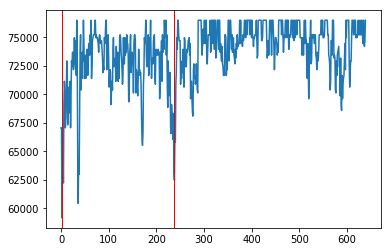

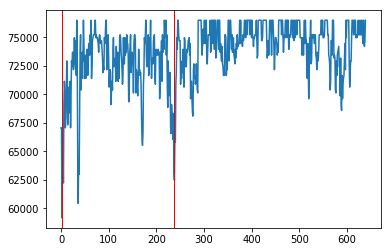

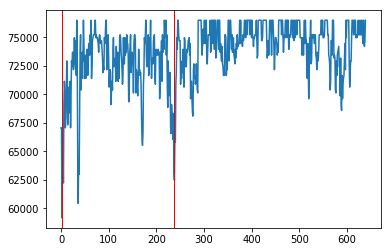

Certainty:  0
Certainty:  0
Certainty:  0


In [ ]:
#newI = mainImg("/Users/Daniel Yang/Desktop/Vision/RoboticsImages/images/training14.png","newImg.png")
#newI = mainImg("/Users/Daniel Yang/Desktop/Vision/RoboticsImages/images/training20.png","newImg.png")
newI = mainImg("/Users/summer19/Desktop/Vision/test1/10.jpg","newImg.png")

In [ ]:
img1 = cv2.imread("/Users/Daniel Yang/Desktop/Vision/RoboticsImages/images/training01.png",0)          # queryImage
img2 = cv2.imread('/Users/Daniel Yang/Desktop/Vision/RoboticsImages/simpleGate.png',0) # trainImage
img1 = newI

orb = cv2.ORB_create()

  # find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

  # create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

 # Match descriptors.
matches = bf.match(des1,des2)

 # Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

 # Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches ,None, flags=2)

cv2.imshow('Original', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()

def showImage1(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')